# Importing Libraries

In [1]:
# importing libraries.

import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

# Loading Data

In [15]:
# defining global variables.

data_set = 'IP'
test_ratio = 0.7
window_size = 25

In [60]:
# function to load the dataset it will load the datastes from the current working directory and return the data and labels.

def load_data(data_set_name):
    data_path = os.path.join(os.getcwd(), '')
    if data_set_name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif data_set_name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif data_set_name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    return data, labels

In [5]:
# function to split the dataset into train and test set it will return the train and test set.

def split_train_test_set(features, labels, test_ratio, random_state=345):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_ratio, random_state=random_state, stratify=labels)
    return X_train, X_test, y_train, y_test

In [6]:
# funnction to apply PCA (principal component analysis) on the dataset, it will return the new dataset and pca object.
# purpose : to reduce the dimensionality of the dataset, it helps in Reducing the redundancy, Noise Removal, Extraction of latent features, Improving the running time of learning algorithms.

def apply_pca(features, num_components=75):
    new_features = np.reshape(features, (-1, features.shape[2]))
    pca = PCA(n_components=num_components, whiten=True)
    new_features = pca.fit_transform(new_features)
    new_features = np.reshape(new_features, (features.shape[0], features.shape[1], num_components))
    return new_features, pca

In [7]:
# function to apply zero padding on the dataset, it will return the padded dataset.
# purpose : it adds zeros to the edges of the image which helps in Handling edge effect, Preserving spatial dimensions, and Maintaining the alignment of pixels.

def pad_with_zeros(features, margin=2):
    new_features = np.zeros((features.shape[0] + 2 * margin, features.shape[1] + 2 * margin, features.shape[2]))
    x_offset = margin
    y_offset = margin
    new_features[x_offset:features.shape[0] + x_offset, y_offset:features.shape[1] + y_offset, :] = features
    return new_features

In [8]:
# function to create image cubes from the dataset, it will return the image cubes and labels.
# purpose : It follows the sliding window approach to extract overlapping patches from the features and assigns corresponding labels to each patch, and helps in input prepration, data augmentation, label association and handling class imbalance .

def create_image_cubes(features, labels, window_size=5, remove_zero_labels=True):
    margin = int((window_size - 1) / 2)
    zero_padded_features = pad_with_zeros(features, margin=margin)
    
    # Split patches
    patches_data = np.zeros((features.shape[0] * features.shape[1], window_size, window_size, features.shape[2]))
    patches_labels = np.zeros((features.shape[0] * features.shape[1]))
    patch_index = 0
    
    for r in range(margin, zero_padded_features.shape[0] - margin):
        for c in range(margin, zero_padded_features.shape[1] - margin):
            patch = zero_padded_features[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patches_data[patch_index, :, :, :] = patch
            patches_labels[patch_index] = labels[r - margin, c - margin]
            patch_index = patch_index + 1
    
    if remove_zero_labels:
        patches_data = patches_data[patches_labels > 0, :, :, :]
        patches_labels = patches_labels[patches_labels > 0]
        patches_labels -= 1
    
    return patches_data, patches_labels

In [10]:
# loading the dataset using load_data function and printing the shape of the dataset.

X, y = load_data(data_set)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (610, 340, 103)
Shape of y: (610, 340)


In [11]:
K = X.shape[2] # number of spectral bands in the image.

In [13]:
# applying PCA on the dataset using apply_pca function with k num of components and printing the shape of the dataset.

K = 30 if data_set == 'IP' else 15
X, pca = apply_pca(X, num_components=K)

print("Shape of X after PCA:", X.shape)

Shape of X after PCA: (610, 340, 15)


In [14]:
# creating image cubes from the dataset using create_image_cubes and window_size is the size of sliding window function and printing the shape of the dataset.
X, y = create_image_cubes(X, y, window_size=window_size)

print("Shape of X after creating image cubes:", X.shape)
print("Shape of y after creating image cubes:", y.shape)

Shape of X after creating image cubes: (42776, 25, 25, 15)
Shape of y after creating image cubes: (42776,)


In [16]:
# splitting the dataset into train and test set using split_train_test_set function and printing the shape of the  dataset for training and testing.

X_train, X_test, y_train, y_test = split_train_test_set(X, y, test_ratio)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (12832, 25, 25, 15)
Shape of X_test: (29944, 25, 25, 15)
Shape of y_train: (12832,)
Shape of y_test: (29944,)


In [19]:
# reshaping the training dataset as per the input layer of the model.

X_train = X_train.reshape(-1, window_size, window_size, K, 1)
print("Reshaped X_train shape:", X_train.shape)

Reshaped X_train shape: (12832, 25, 25, 15, 1)


In [18]:
y_train = np_utils.to_categorical(y_train)
print("Categorical y_train shape:", y_train.shape)


Categorical y_train shape: (12832, 9)


In [20]:
S = window_size
L = K
output_units = 9 if (data_set == 'PU' or data_set == 'PC') else 16

print("Value of S:", S)
print("Value of L:", L)
print("Value of output_units:", output_units)

Value of S: 25
Value of L: 15
Value of output_units: 9


In [21]:
# Input layer
input_layer = Input((S, S, L, 1))

# Convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
conv3d_shape = conv_layer3.shape
conv_layer3_reshaped = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(conv_layer3_reshaped)

# Flatten layer
flatten_layer = Flatten()(conv_layer4)

# Fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)

# Output layer
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)


In [23]:
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 25, 15, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 23, 23, 9, 8)      512       
                                                                 
 conv3d_1 (Conv3D)           (None, 21, 21, 5, 16)     5776      
                                                                 
 conv3d_2 (Conv3D)           (None, 19, 19, 3, 32)     13856     
                                                                 
 reshape (Reshape)           (None, 19, 19, 96)        0         
                                                                 
 conv2d (Conv2D)             (None, 17, 17, 64)        55360     
                                                                 
 flatten (Flatten)           (None, 18496)             0   

In [24]:
# compiling the model using custom adam optimizer.
adam = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [25]:
# It will save the best model based on the accuracy of the model. named as best-model-{data_set}.hdf5
filepath = f"best-model-{data_set}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [27]:
# training the model using fit function and saving the history of the model.

history = model.fit(x=X_train, y=y_train, batch_size=256, epochs=50, callbacks=callbacks_list)

Epoch 1/50
51/51 [==============================] - 59s 1s/step - loss: 0.6144 - accuracy: 0.7892
Epoch 2/50
51/51 [==============================] - 59s 1s/step - loss: 0.0920 - accuracy: 0.9719
Epoch 3/50
51/51 [==============================] - 57s 1s/step - loss: 0.0281 - accuracy: 0.9910
Epoch 4/50
51/51 [==============================] - 60s 1s/step - loss: 0.0144 - accuracy: 0.9955
Epoch 5/50
51/51 [==============================] - 60s 1s/step - loss: 0.0374 - accuracy: 0.9899
Epoch 6/50
51/51 [==============================] - 60s 1s/step - loss: 0.0146 - accuracy: 0.9964
Epoch 7/50
51/51 [==============================] - 59s 1s/step - loss: 0.0075 - accuracy: 0.9978
Epoch 8/50
51/51 [==============================] - 58s 1s/step - loss: 0.0034 - accuracy: 0.9988
Epoch 9/50
51/51 [==============================] - 59s 1s/step - loss: 0.0080 - accuracy: 0.9979
Epoch 10/50
51/51 [==============================] - 55s 1s/step - loss: 0.0036 - accuracy: 0.9994
Epoch 11/50
51/51 [

In [69]:
# saving the model as best-model-{data_set}.hdf5

model.save(f"best-model-{data_set}.hdf5")

# Testing

In [28]:
# Reshaping the test dataset as per the input layer of the model.

X_test = X_test.reshape(-1, window_size, window_size, K, 1)
print("Reshaped X_test shape:", X_test.shape)

Reshaped X_test shape: (29944, 25, 25, 15, 1)


In [50]:
# labels of the test dataset.

y_test = np_utils.to_categorical(y_test)
y_test.shape

(29944, 9)

In [51]:

# Predicting the test dataset using the model and printing the classification report. 

Y_pred_test = model.predict(X_test)
y_pred_test = np.argmax(Y_pred_test, axis=1)
y_test = np.argmax(y_test, axis=1)

y_pred_test.shape, y_test.shape



classification = classification_report(y_test, y_pred_test)
print(classification)

936/936 [==============================] - 26s 28ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4642
           1       1.00      1.00      1.00     13055
           2       1.00      1.00      1.00      1469
           3       1.00      1.00      1.00      2145
           4       1.00      1.00      1.00       942
           5       1.00      1.00      1.00      3520
           6       1.00      1.00      1.00       931
           7       1.00      1.00      1.00      2577
           8       1.00      1.00      1.00       663

    accuracy                           1.00     29944
   macro avg       1.00      1.00      1.00     29944
weighted avg       1.00      1.00      1.00     29944



In [52]:
# function for the average accuracy and each class accuracy using confusion matrix.  

def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(np.divide(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [55]:
# function for getting the Test Loss, Test Accuracy, Clssification report, OA, AA and  kappa coefficient. 

def reports(X_test, y_test, name):
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    y_test = y_test.reshape(-1, 1)
    
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn', 'Grass-pasture', 'Grass-trees',
                        'Grass-pasture-mowed', 'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives', 'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1', 'Brocoli_green_weeds_2', 'Fallow', 'Fallow_rough_plow',
                        'Fallow_smooth', 'Stubble', 'Celery', 'Grapes_untrained', 'Soil_vinyard_develop',
                        'Corn_senesced_green_weeds', 'Lettuce_romaine_4wk', 'Lettuce_romaine_5wk',
                        'Lettuce_romaine_6wk', 'Lettuce_romaine_7wk', 'Vinyard_untrained', 'Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt', 'Meadows', 'Gravel', 'Trees', 'Painted metal sheets', 'Bare Soil', 'Bitumen',
                        'Self-Blocking Bricks', 'Shadows']
    
    classification = classification_report(y_test, y_pred, target_names=target_names)
    oa = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(y_test, y_pred)
    score = model.evaluate(X_test, np_utils.to_categorical(y_test), batch_size=32)
    Test_Loss = score[0] * 100
    Test_accuracy = score[1] * 100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa * 100, each_acc * 100, aa * 100, kappa * 100

In [56]:
# It will generate a full report which contains Test Loss, Test Accuracy, Clssification report, OA, AA and  kappa coefficient etc.

classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(X_test,y_test,data_set)
classification = str(classification)
confusion = str(confusion)
file_name = f"classification_report_{data_set}.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

936/936 [==============================] - 30s 32ms/step - loss: 2.3713e-04 - accuracy: 0.9999


In [57]:
# The Patch function is dividing a larger data array into smaller patches, which can be processed independently. it helps to reduce the memory usage and localized analysis.

def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [62]:
# Load the data from the .mat file.

X, y = load_data(data_set)

In [63]:
# Defining the parameter for the model and patch function.

height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = window_size
num_components = K

In [64]:
# Applying the PCA on the data.

X,pca = apply_pca(X, num_components=num_components)


In [65]:
# Padding the data with zeros.

X = pad_with_zeros(X, PATCH_SIZE//2)

In [66]:
# Calculating the predicted image. here this code segment performs pixel-wise classification using the trained model. It extracts patches centered around each pixel, feeds them into the model for prediction, and assigns the predicted class labels to the corresponding locations in the output array.

outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

1/1 [==============================] - 0s 49ms/step


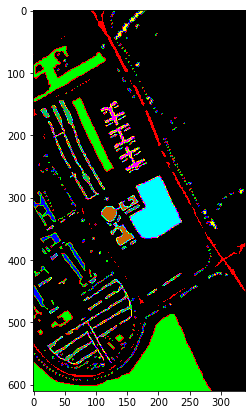

In [67]:
# Actual ground truth image. 

ground_truth = spectral.imshow(classes = y,figsize =(7,7)) 

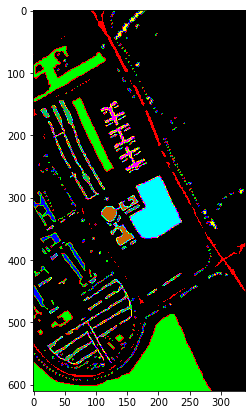

In [70]:
# Predicted ground truth image.

predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))